In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from sklearn import preprocessing

### Load data

In [2]:
dname = os.getcwd() + '/../../data/'

In [3]:
CORRECT_CATEGORY_BLOC = np.load(dname + 'CORRECT_CATEGORY_BLOC.npy', allow_pickle=True)
RESPONSE_CATEGORY_BLOC = np.load(dname + 'RESPONSE_CATEGORY_BLOC.npy', allow_pickle=True)
TRIAL_TYPE = np.load(dname + 'TRIAL_TYPE.npy')
MODALITY = np.load(dname + 'MODALITY.npy', allow_pickle=True)
n_sujs, n_blocs, n_trials = CORRECT_CATEGORY_BLOC.shape
CORRECT_CATEGORY_BLOC.shape

(97, 14, 30)

In [4]:
modalities = np.array(['audio', 'visual', 'spatial'])
modalities_plot = np.array(['Auditory', 'Visual', 'Spatial (visual)'])
n_modalities = np.size(modalities)

In [5]:
trial_types = {
    64: r'$\emptyset$', 
    68: r'$|$',
    66: r'$—$',
    32: r'$| + —$',
    8:  r'$\curvearrowleft$',
    16: r'$\curvearrowright$',
    20: r'$\curvearrowright + |$',
    18: r'$\curvearrowright + —$',
    65: r'$\bigstar$',
    69: r'$\bigstar + |$',
    67: r'$\bigstar + —$',
}
n_trial_types = len(trial_types.keys())
n_trial_types

11

### Reshape arrays

In [6]:
RESPONSE_CATEGORY = RESPONSE_CATEGORY_BLOC.reshape((n_sujs, -1))
CORRECT_CATEGORY = CORRECT_CATEGORY_BLOC.reshape((n_sujs, -1))
TRIAL_TYPE = TRIAL_TYPE.reshape((n_sujs, -1))

### Build confusion matrices of models. 

In [7]:
# There are actually only 4 possible matrices: 
# CARFUL: the matrix are build for the specific ordering butterfly, square, zorro
n_labels = 3
n_matrices = 4
MATRICES = np.zeros((n_matrices, n_labels, n_labels))

# Random
MATRICES[0] = 1./n_labels

# x rotated
MATRICES[1][0, 2] = 1
MATRICES[1][1, 0] = 1
MATRICES[1][2, 1] = 1

# y rotated
MATRICES[2][0, 1] = 1
MATRICES[2][1, 2] = 1
MATRICES[2][2, 0] = 1

# No rotation
MATRICES[3][0, 0] = 1
MATRICES[3][1, 1] = 1
MATRICES[3][2, 2] = 1

### Fit matrices per suj and per generalization type.

In [8]:
# Inverse temperature parameter
n_betas = 200
betas = np.linspace(*[0.05, 0.5], n_betas)

array([0.05      , 0.05226131, 0.05452261, 0.05678392, 0.05904523,
       0.06130653, 0.06356784, 0.06582915, 0.06809045, 0.07035176,
       0.07261307, 0.07487437, 0.07713568, 0.07939698, 0.08165829,
       0.0839196 , 0.0861809 , 0.08844221, 0.09070352, 0.09296482,
       0.09522613, 0.09748744, 0.09974874, 0.10201005, 0.10427136,
       0.10653266, 0.10879397, 0.11105528, 0.11331658, 0.11557789,
       0.1178392 , 0.1201005 , 0.12236181, 0.12462312, 0.12688442,
       0.12914573, 0.13140704, 0.13366834, 0.13592965, 0.13819095,
       0.14045226, 0.14271357, 0.14497487, 0.14723618, 0.14949749,
       0.15175879, 0.1540201 , 0.15628141, 0.15854271, 0.16080402,
       0.16306533, 0.16532663, 0.16758794, 0.16984925, 0.17211055,
       0.17437186, 0.17663317, 0.17889447, 0.18115578, 0.18341709,
       0.18567839, 0.1879397 , 0.19020101, 0.19246231, 0.19472362,
       0.19698492, 0.19924623, 0.20150754, 0.20376884, 0.20603015,
       0.20829146, 0.21055276, 0.21281407, 0.21507538, 0.21733

In [9]:
LL = np.full((n_sujs, n_trial_types, n_matrices, n_betas), np.nan)
for i in range(n_sujs):
    for j, trial_type in enumerate(trial_types.keys()):
        
        # Get subject responses
        idx = TRIAL_TYPE[i] == trial_type
        x = CORRECT_CATEGORY[i][idx]
        y = RESPONSE_CATEGORY[i][idx]
        
        # Convert labels into integers
        le = preprocessing.LabelEncoder()
        le.fit(x)
        x = le.transform(x)
        y = le.transform(y)
        
        for k in range(n_matrices):
            for l, beta in enumerate(betas):
                
                # Get model's response probability from matrices
                ps = MATRICES[k][x]
                
                # Apply softmax
                ps = np.exp(ps/beta)/np.sum(np.exp(ps/beta), axis=1, keepdims=True)
                
                # Get model's reponse probability associated with the participant's response
                ps = ps[np.arange(ps.shape[0]), y]
                
                # Store log-likelihood
                LL[i, j, k, l] = np.mean(np.log2(ps))

### Explore best fitting matrix per trial type per subject

In [10]:
# Choose the best beta
LL_beta = np.max(LL, axis=3)
#LL_beta = LL[:, :, :, 12] # ... or choose by hand beta = 0.32

# Select best fitting matrix
best_fitting_matrix = np.argmax(LL_beta, axis=-1)
best_fitting_matrix.shape

(97, 11)

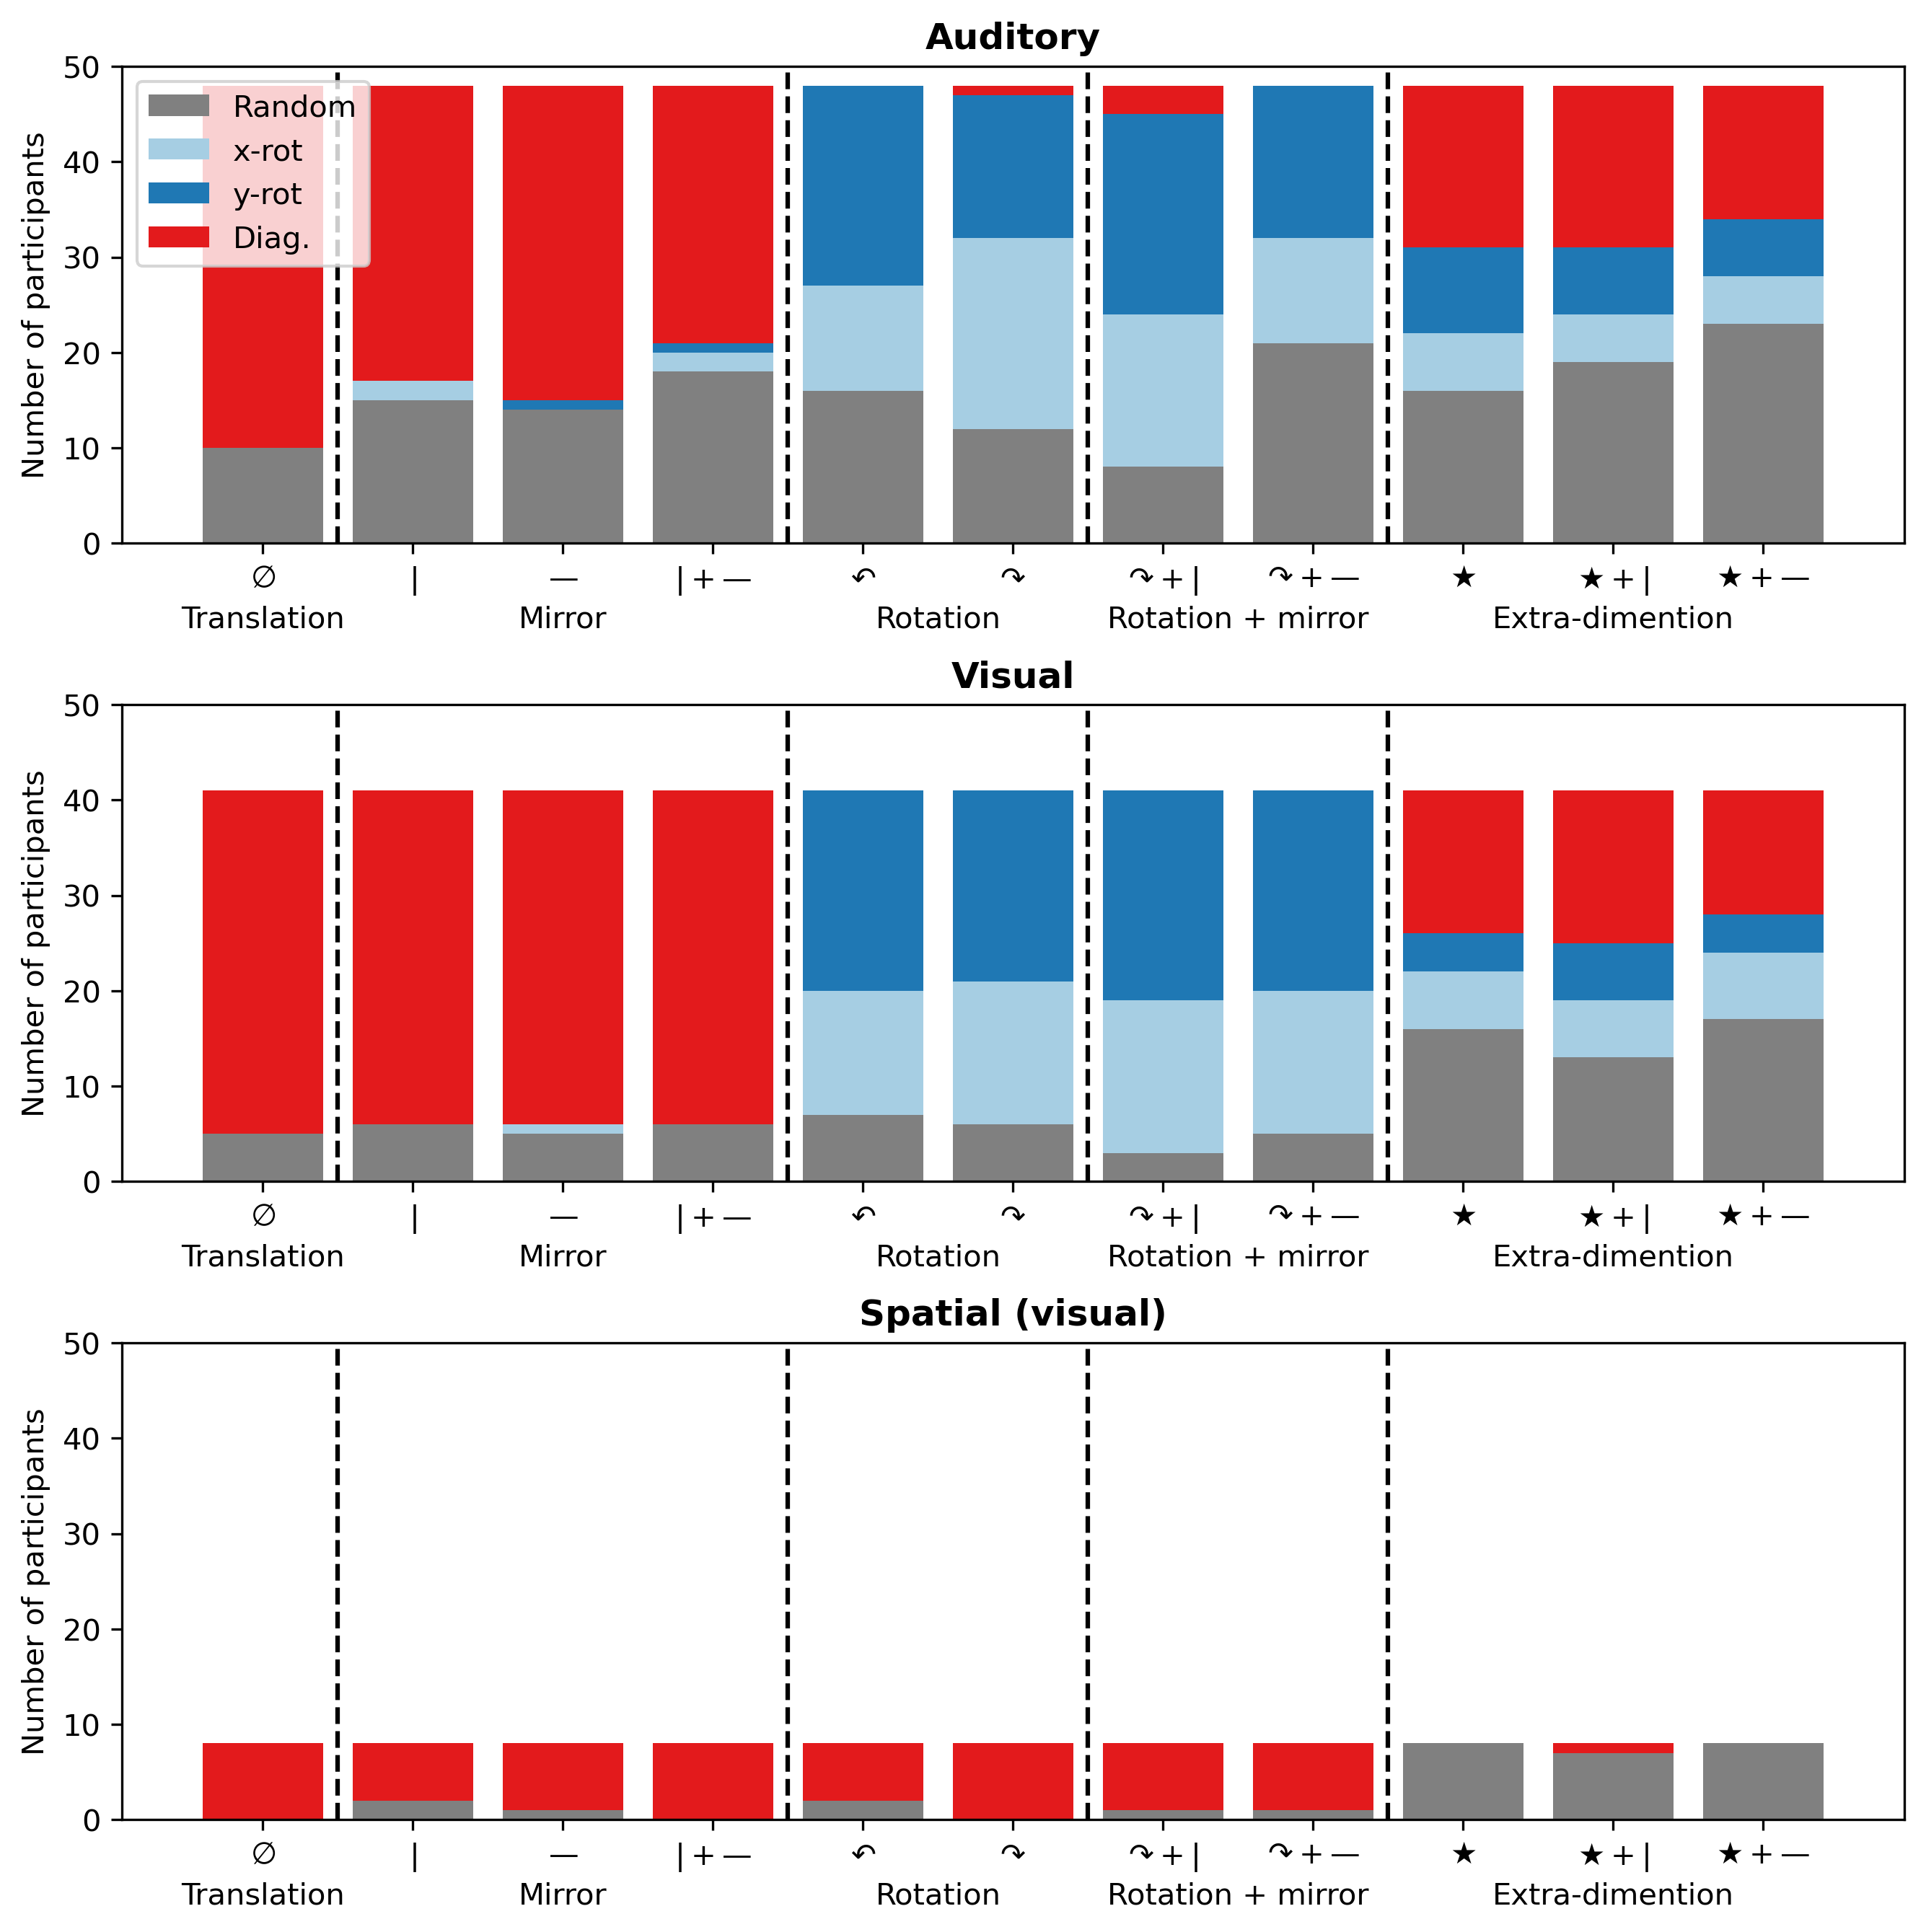

In [11]:
# Prepare figure
fig, axs = plt.subplots(n_modalities, 1, figsize=(9, 9), dpi=300, facecolor='w')

# Define colors
cmap = matplotlib.cm.get_cmap('Paired')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = ['grey', cmap(norm(0)), cmap(norm(0.1)), cmap(norm(0.45))]

for i, (ax, modality, modality_plot) in enumerate(zip(axs, modalities, modalities_plot)):
    for j, trial_type in enumerate(trial_types.keys()):

        # Select subjects for this modality
        idx = MODALITY == modality
        
        # Get best fitting models for this trial type
        m = best_fitting_matrix[idx, j]

        # Stack best fitting matrix
        bottom = 0
        for k, (color, label) in enumerate(zip(colors, ['Random', 'x-rot','y-rot', 'Diag.'])):
            y = np.sum(m == k)
            label = label if j == 0 else '_no_label'
            ax.bar(trial_types[trial_type], y, color=color, bottom=bottom, label=label)
            bottom += y

    # Aesthetics
    for x in [0.5, 3.5, 5.5, 7.5]:
        ax.axvline(x, color='k', alpha=1, ls='--')
    for x, text in zip([0, 2, 4.5, 6.5, 9], ['Translation', 'Mirror', 'Rotation', 'Rotation + mirror', 'Extra-dimention']):
        ax.text(x, -8, text, ha='center', va='center')
    ax.set_title(modality_plot, fontweight='bold')
    ax.set_ylim(0, 50)
    ax.set_ylabel('Number of participants')
    if i == 0: ax.legend(loc=2)

plt.tight_layout()
fig.savefig('figures/fig_6.png')

### Explore beta values

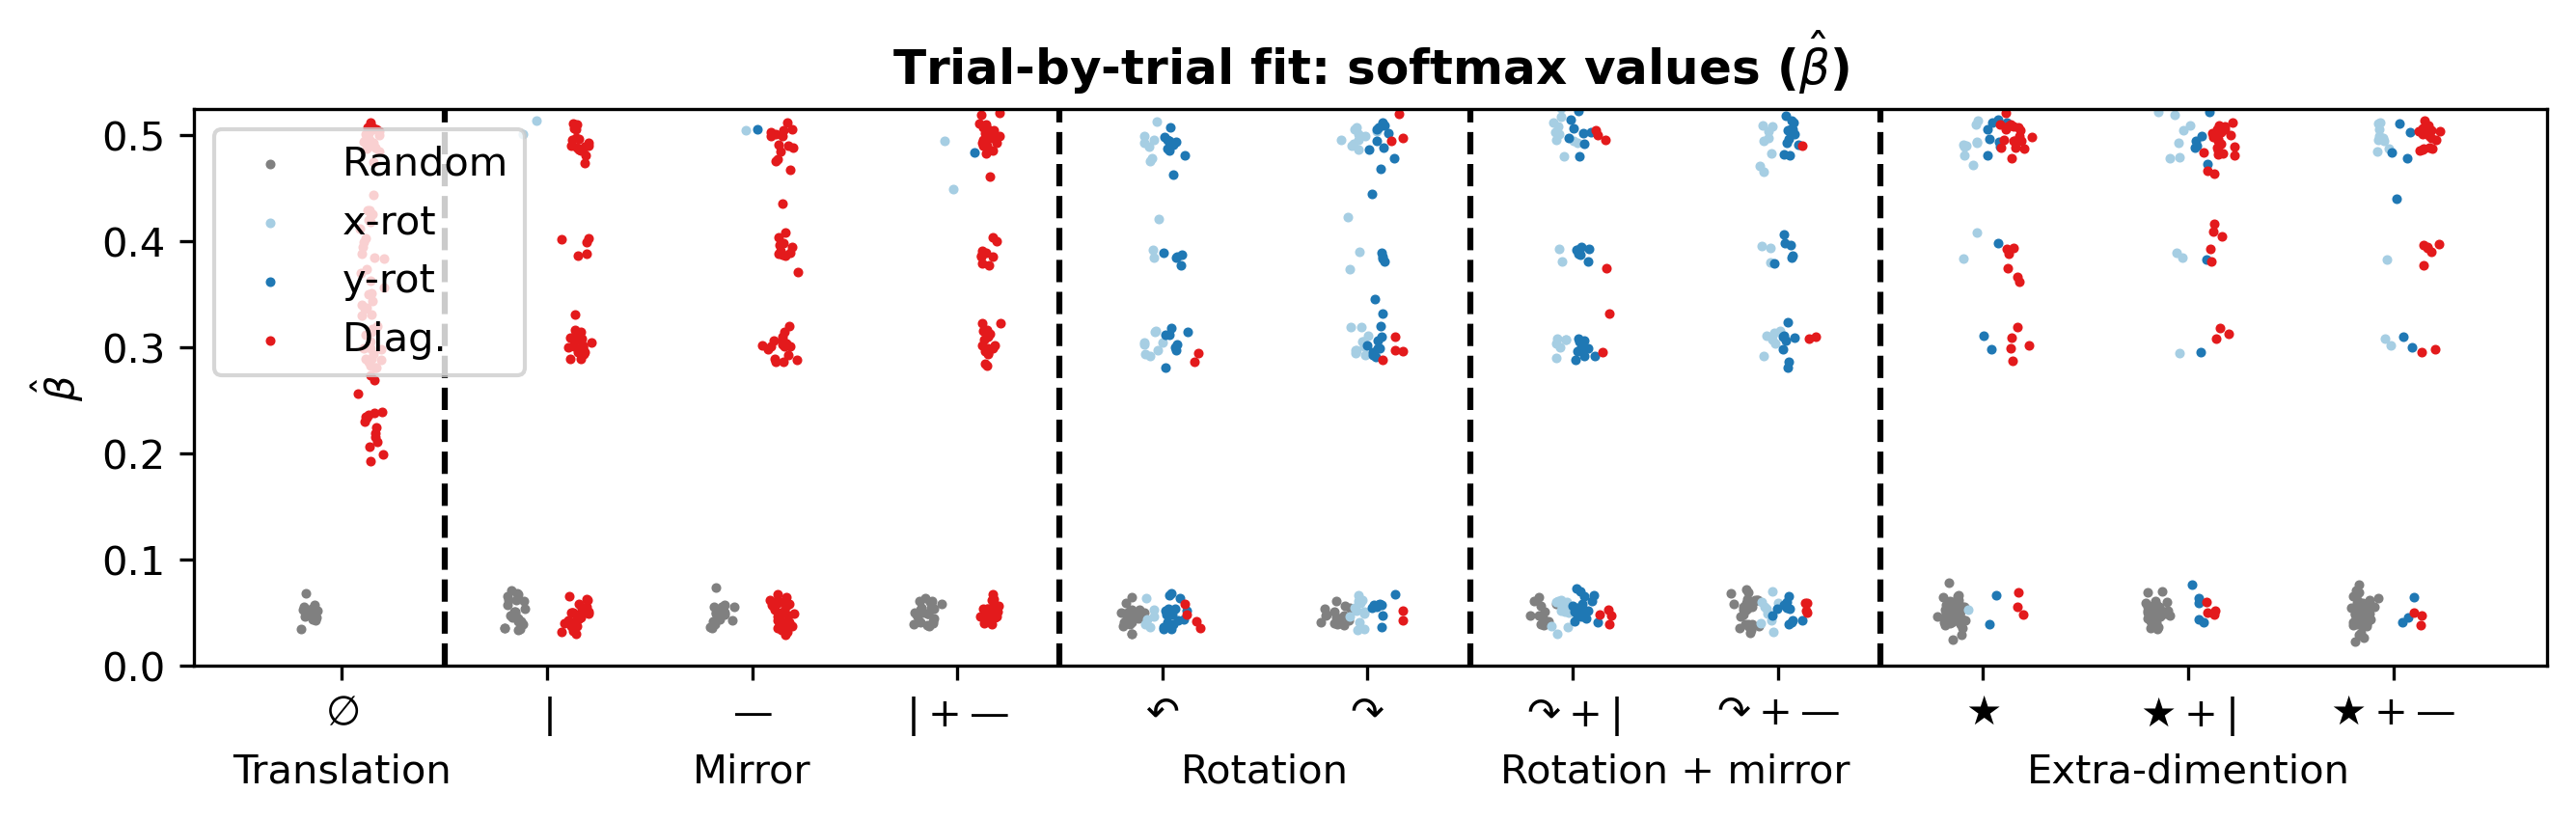

In [12]:
# Prepare figure
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=300, facecolor='w')

# Define colors
cmap = matplotlib.cm.get_cmap('Paired')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = ['grey', cmap(norm(0)), cmap(norm(0.1)), cmap(norm(0.45))]

for i, trial_type in enumerate(trial_types.keys()):
    for j, (color, label) in enumerate(zip(colors, ['Random', 'x-rot','y-rot', 'Diag.'])):

        # Get best fitting models for this trial type and this matrices
        idx = best_fitting_matrix[:, i] == j
        
        # Get betas associated with the best fitting matrix for this trial type
        y = betas[np.argmax(LL[idx, i, j], axis=1)]
        
        # Labels
        label = label if i == 0 else '_no_label'
        
        # Plot the distribution
        ax.scatter(
            np.ones(y.size) * i - 0.15 + 0.1*j + np.random.normal(0, 0.03, y.size), 
            y + np.random.normal(0, 0.01, y.size), 
            color=color, 
            s=2,
            label=label
        )
        
# Aesthetics
for x in [0.5, 3.5, 5.5, 7.5]:
    ax.axvline(x, color='k', alpha=1, ls='--')
for x, text in zip([0, 2, 4.5, 6.5, 9], ['Translation', 'Mirror', 'Rotation', 'Rotation + mirror', 'Extra-dimention']):
    ax.text(x, -0.1, text, ha='center', va='center')
ax.set_title(r'Trial-by-trial fit: softmax values ($\hat{\beta}$)', fontweight='bold')
ax.set_ylim(0, np.max(betas)*1.05)
ax.set_ylabel(r'$\hat{\beta}$')
ax.legend(loc=2)
ax.set_xticks(range(n_trial_types))
ax.set_xticklabels(trial_types.values())

plt.tight_layout()
fig.savefig('figures/fig_7.png')